# Imports

In [1]:
import sys
print(sys.executable)

C:\Users\edlyn\.conda\envs\turbulence\python.exe


Number of threads to use

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = '15' # set cores for numpy
os.environ['TF_INTER_OP_PARALLELISM_THREADS'] = '15' # set cores for TF
os.environ['TF_INTRA_OP_PARALLELISM_THREADS'] = '15'

Configure TensorFlow

In [3]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow logs
print(tf.__version__)

2.10.0


Remaining imports

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import time
from pathlib import Path

# Data Handling

Data loading

In [5]:
# Data is generated from Gen_data.ipynb. 
# ATTENTION: Get the data from Teams! File is too large to upload to GitHub
fln = r"C:\Users\edlyn\Downloads\Generated_data.h5"
hf  = h5py.File(fln,'r')

# Check the contents of the HDF5 file
print("Contents of the HDF5 file:", list(hf.keys()))

Contents of the HDF5 file: ['dissipation_rates', 'kinetic_energy', 'velocity_field']


Initializing the velocity field 

In [6]:
downsample = 1 # Skip every n-th sample to get varying data. Otherwise the data is to similar and large. Set to 1 to use all data.
Re = 30
data_len = 3000
transient = 200 # Number of transient steps to ignore from our data
Nx = 48
Nu = 2

# Ensure the HDF5 file is open before accessing the data
fln = r"C:\Users\edlyn\Downloads\Generated_data.h5"
hf  = h5py.File(fln,'r')
U = np.array(hf.get('velocity_field')[transient:transient+data_len:downsample], dtype=np.float32)
hf.close()

# Check the length of the velocity field
print("Shape of the velocity field:", U.shape)  
print(f"So, the velocity field has {data_len/downsample} samples, each sample has 48x48 grid points and each grid point has 2 components (ux,uy)")

# Define the number of grid points in x and y directions
N_x     = U.shape[1] 
N_y     = U.shape[2]

Shape of the velocity field: (3000, 48, 48, 2)
So, the velocity field has 3000.0 samples, each sample has 48x48 grid points and each grid point has 2 components (ux,uy)


Splitting the data into train, validation and test sets, and batching the data

In [7]:
b_size = 50   #batch_size
n_batches = data_len//b_size  #number of batches

train_batches = int(n_batches*(5/6))
val_batches = int(n_batches*(1/6))

print("Percentage of data used for training:", 100*(1-val_batches/n_batches))
print("Percentage of data used for validation:", 100*val_batches/n_batches)

Percentage of data used for training: 83.33333333333334
Percentage of data used for validation: 16.666666666666668


In [8]:
def batch_data(U, b_size, n_batches):
    
    '''
    Splits the data in batches. Each batch is created by sampling the signal with interval
    equal to n_batches
    '''
    data = np.zeros((n_batches, b_size, U.shape[1], U.shape[2], U.shape[3]))    
    for i in range(n_batches):
        data[i] = U[i::n_batches].copy()

    return data

In [9]:
# training data
U_tt = np.array(U[:train_batches*b_size].copy())            # to be used for random batches
print("Shape of the training data before batching:", U_tt.shape)
U_train = batch_data(U_tt, b_size, train_batches).astype('float32') # to be used for randomly shuffled batches
print("Shape of the training data after batching:", U_train.shape, "\n")

# validation data
U_vv = np.array(U[train_batches*b_size:
                         train_batches*b_size+b_size*val_batches].copy())
print("Shape of the validation data before batching:", U_vv.shape)
U_val = batch_data(U_vv, b_size, val_batches).astype('float32')         
print("Shape of the validation data after batching:", U_val.shape)

# Delete the original data to save memory:
del U_tt, U_vv

Shape of the training data before batching: (2500, 48, 48, 2)
Shape of the training data after batching: (50, 50, 48, 48, 2) 

Shape of the validation data before batching: (500, 48, 48, 2)
Shape of the validation data after batching: (10, 50, 48, 48, 2)


# Autoencoder Functions

In [10]:
'''
Changes: included loss mse and optimizer as inputs to train_step
'''
#@tf.function #this creates the tf graph
def model(inputs, enc_mods, dec_mods, is_train=False):
    
    '''
    Multiscale autoencoder, taken from Hasegawa 2020. The contribution of the CNNs at different
    scales are simply summed.
    '''
        
    # sum of the contributions of the different CNNs
    encoded = 0
    for enc_mod in enc_mods:
        encoded += enc_mod(inputs, training=is_train)
            
    decoded = 0
    for dec_mod in dec_mods:
        decoded += dec_mod(encoded, training=is_train)
        
    return encoded, decoded


#@tf.function #this creates the tf graph
def train_step(inputs, enc_mods, dec_mods, Loss_Mse, optimizer, train=True):
    
    """
    Trains the model by minimizing the loss between input and output
    """
    
    # autoencoded field
    decoded  = model(inputs, enc_mods, dec_mods, is_train=train)[-1]

    # loss with respect to the data
    loss = Loss_Mse(inputs, decoded)
    
    # compute and apply gradients inside tf.function environment for computational efficiency
    if train:
        # create a variable with all the weights to perform gradient descent on
        # appending lists is done by plus sign
        varss = [] #+ Dense.trainable_weights
        for enc_mod in enc_mods:
            varss  += enc_mod.trainable_weights
        for dec_mod in dec_mods:
            varss +=  dec_mod.trainable_weights
        
        with tf.GradientTape() as tape:
            decoded  = model(inputs, enc_mods, dec_mods, is_train=train)[-1]
            loss = Loss_Mse(inputs, decoded)
        grads = tape.gradient(loss, varss)
        optimizer.apply_gradients(zip(grads, varss))
    
    return loss


In [11]:
def periodic_padding(image, padding=1, asym=False):
    '''
    Create a periodic padding (same of np.pad('wrap')) around the image, 
    to mimic periodic boundary conditions.
    When asym=True on the right and lower edges an additional column/row is added
    '''
        
    if asym:
        lower_pad = image[:,:padding+1,:]
    else:
        lower_pad = image[:,:padding,:]
    
    if padding != 0:
        upper_pad     = image[:,-padding:,:]
        partial_image = tf.concat([upper_pad, image, lower_pad], axis=1)
    else:
        partial_image = tf.concat([image, lower_pad], axis=1)
        
    if asym:
        right_pad = partial_image[:,:,:padding+1] 
    else:
        right_pad = partial_image[:,:,:padding]
    
    if padding != 0:
        left_pad = partial_image[:,:,-padding:]
        padded_image = tf.concat([left_pad, partial_image, right_pad], axis=2)
    else:
        padded_image = tf.concat([partial_image, right_pad], axis=2)

    return padded_image

In [12]:
class PerPad2D(tf.keras.layers.Layer):
    """
    Periodic Padding layer
    """
    def __init__(self, padding=1, asym=False, **kwargs):
        self.padding = padding
        self.asym    = asym
        super(PerPad2D, self).__init__(**kwargs)
        
    def get_config(self): #needed to be able to save and load the model with this layer
        config = super(PerPad2D, self).get_config()
        config.update({
            'padding': self.padding,
            'asym': self.asym,
        })
        return config

    def call(self, x):
        return periodic_padding(x, self.padding, self.asym)

# Create the Model

In [13]:
'''
TODO: hyperparameter tuning
'''

## define the model
# we do not have pooling and upsampling, instead we use stride=2
N_lat         = 5                          # change N_lat hyperparameter
last_conv_dep = 1                          #output depth of last conv layer, if we want to include dissipation rate and vorticity, increase this number
n_fil         = [6,12,24,last_conv_dep]          #number of filters encoder
n_dec         = [24,12,6,3]                #number of filters decoder
N_parallel    = 3                          #number of parallel CNNs for multiscale
ker_size      = [(3,3), (5,5), (7,7)]      #kernel sizes
N_layers      = 4                          #number of layers in every CNN
act           = 'tanh'                     #activation function

pad_enc       = 'valid'         #no padding in the conv layer
pad_dec       = 'valid'
p_size        = [0,1,2]         #stride = 2 periodic padding size          
p_fin         = [1,2,3]         #stride = 1 periodic padding size
p_dec         = 1               #padding in the first decoder layer
p_crop        = U.shape[1]      #crop size of the output equal to input size


In [14]:
#initialize the encoders and decoders with different kernel sizes    
enc_mods      = [None]*(N_parallel)
dec_mods      = [None]*(N_parallel)    
for i in range(N_parallel):
    enc_mods[i] = tf.keras.Sequential(name='Enc_' + str(i))
    dec_mods[i] = tf.keras.Sequential(name='Dec_' + str(i))

In [15]:
#generate encoder layers    
for j in range(N_parallel):
    for i in range(N_layers):      

        #stride=2 padding and conv
        enc_mods[j].add(PerPad2D(padding=p_size[j], asym=True,
                                          name='Enc_' + str(j)+'_PerPad_'+str(i)))
        enc_mods[j].add(tf.keras.layers.Conv2D(filters = n_fil[i], kernel_size=ker_size[j],
                                      activation=act, padding=pad_enc, strides=2,
                        name='Enc_' + str(j)+'_ConvLayer_'+str(i)))

        #stride=1 padding and conv
        if i<N_layers-1:
            enc_mods[j].add(PerPad2D(padding=p_fin[j], asym=False,
                                                      name='Enc_'+str(j)+'_Add_PerPad1_'+str(i)))
            enc_mods[j].add(tf.keras.layers.Conv2D(filters=n_fil[i],
                                                    kernel_size=ker_size[j], 
                                                activation=act,padding=pad_dec,strides=1,
                                                    name='Enc_'+str(j)+'_Add_Layer1_'+str(i)))  
    # Add fully connected layer
    enc_mods[j].add(tf.keras.layers.Flatten(name='Enc_' + str(j) + '_Flatten'))
    enc_mods[j].add(tf.keras.layers.Dense(N_lat, activation='linear', name='Enc_' + str(j) + '_Dense'))

In [16]:
#explicitly obtain the size of the latent space
output = U_train[0]
for i, layer in enumerate(enc_mods[-1].layers):
    output = layer(output)  # Forward pass through the current layer
    if i == (N_layers - 1) * 4 + 1:  # Stop after the 4th layer (index 3)
        conv_out_shape = output.shape[1:]
        conv_out_size = np.prod(conv_out_shape)
        print("Output shape of the last convolutional layer:", conv_out_shape)
        print("SIze of last convolutional output: ", conv_out_size)
    elif i == (N_layers - 1) * 4 + 2 + 1:
         print("Size of the latent space:", output.shape[-1])  

Output shape of the last convolutional layer: (3, 3, 1)
SIze of last convolutional output:  9
Size of the latent space: 5


In [17]:
_#generate decoder layers            
for j in range(N_parallel):
    
    # Add fully connected layer first to map latent space to the appropriate dimensions
    dec_mods[j].add(tf.keras.layers.Dense(conv_out_size, activation='linear', name='Dec_' + str(j) + '_Dense'))
    dec_mods[j].add(tf.keras.layers.Reshape(conv_out_shape, name='Dec_' + str(j) + '_Reshape'))


    for i in range(N_layers):

        #initial padding of latent space
        if i==0: 
            dec_mods[j].add(PerPad2D(padding=p_dec, asym=False,
                                          name='Dec_' + str(j)+'_PerPad_'+str(i))) 
        
        #Transpose convolution with stride = 2 
        dec_mods[j].add(tf.keras.layers.Conv2DTranspose(filters = n_dec[i],
                                       output_padding=None,kernel_size=ker_size[j],
                                      activation=act, padding=pad_dec, strides=2,
                            name='Dec_' + str(j)+'_ConvLayer_'+str(i)))
        
        #Convolution with stride=1
        if  i<N_layers-1:       
            dec_mods[j].add(tf.keras.layers.Conv2D(filters=n_dec[i],
                                        kernel_size=ker_size[j], 
                                       activation=act,padding=pad_dec,strides=1,
                                      name='Dec_' + str(j)+'_ConvLayer1_'+str(i)))

    #crop and final linear convolution with stride=1
    dec_mods[j].add(tf.keras.layers.CenterCrop(p_crop + 2*p_fin[j],
                                                   p_crop+ 2*p_fin[j],
                            name='Dec_' + str(j)+'_Crop_'+str(i)))
    dec_mods[j].add(tf.keras.layers.Conv2D(filters=U.shape[3],
                                            kernel_size=ker_size[j], 
                                            activation='linear',padding=pad_dec,strides=1,
                                              name='Dec_' + str(j)+'_Final_Layer'))

In [18]:
# run the model once to print summary
enc0, dec0 = model(U_train[0], enc_mods, dec_mods)
print('latent space size:', N_lat)
print('physical space size:', U[0].flatten().shape)
print('')
for j in range(3):
    enc_mods[j].summary()
for j in range(3):
    dec_mods[j].summary()

latent space size: 5
physical space size: (4608,)

Model: "Enc_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Enc_0_PerPad_0 (PerPad2D)   (50, 49, 49, 2)           0         
                                                                 
 Enc_0_ConvLayer_0 (Conv2D)  (50, 24, 24, 6)           114       
                                                                 
 Enc_0_Add_PerPad1_0 (PerPad  (50, 26, 26, 6)          0         
 2D)                                                             
                                                                 
 Enc_0_Add_Layer1_0 (Conv2D)  (50, 24, 24, 6)          330       
                                                                 
 Enc_0_PerPad_1 (PerPad2D)   (50, 25, 25, 6)           0         
                                                                 
 Enc_0_ConvLayer_1 (Conv2D)  (50, 12, 12, 12)          660       
          

# Train the Model

In [19]:
n_epochs = 2
rng = np.random.default_rng() #random generator for later shufflinh

# plotting and saving
plt.rcParams["figure.figsize"] = (15,4)
plt.rcParams["font.size"]  = 20
path = './data/48_RE30_'+str(N_lat) #to save model


#define loss, optimizer and initial learning rate   
Loss_Mse    = tf.keras.losses.MeanSquaredError()
optimizer   = tf.keras.optimizers.Adam(amsgrad=True) #amsgrad True for better convergence

l_rate      = 0.002
optimizer.learning_rate = l_rate
lrate_update = True     # flag for l_rate updating
lrate_mult   = 0.75     # decrease by this factore the l_rate 
N_lr         = 100      # number of epochs before which the l_rate is not updated

# quantities to check and store the training and validation loss and the training goes on
old_loss      = np.zeros(n_epochs)      # needed to evaluate training loss convergence to update l_rate
tloss_plot    = np.zeros(n_epochs)      # training loss
vloss_plot    = np.zeros(n_epochs)      # validation loss
old_loss[0]   = 1e6                      # initial value has to be high
N_check       = 1                        # each N_check epochs we check convergence and validation loss
patience      = 200                      # if the val_loss has not gone down in the last patience epochs, early stop
last_save     = patience
t             = 1                        # initial (not important value) to monitor the time of the training

In [20]:
n_batches   = min(n_batches, len(U_train))  # Ensure n_batches does not exceed the size of U_train
for epoch in range(n_epochs):
    
    if epoch - last_save > patience: break #early stop
                
    #Perform gradient descent for all the batches every epoch
    loss_0 = 0
    rng.shuffle(U_train, axis=0) #shuffle batches
    for j in range(train_batches):
        loss    = train_step(U_train[j], enc_mods, dec_mods, Loss_Mse, optimizer)
        loss_0 += loss
    
    #save train loss
    tloss_plot[epoch]  = loss_0.numpy()/train_batches
    
    # every N epochs checks the convergence of the training loss and val loss
    if (epoch%N_check==0):
        
        #Compute Validation Loss
        loss_val        = 0
        for j in range(val_batches):
            loss        = train_step(U_val[j], enc_mods, dec_mods, Loss_Mse, optimizer, train=False)
            loss_val   += loss
        
        #save validation loss
        vloss_plot[epoch]  = loss_val.numpy()/val_batches 
        
        # Decreases the learning rate if the training loss is not going down with respect to 
        # N_lr epochs before
        if epoch > N_lr and lrate_update:
            #check if the training loss is smaller than the average training loss N_lr epochs ago
            tt_loss   = np.mean(tloss_plot[epoch-N_lr:epoch])
            if tt_loss > old_loss[epoch-N_lr]:
                #if it is larger, load optimal val loss weights and decrease learning rate
                print('LOADING MINIMUM')
                for i in range(N_parallel):
                    enc_mods[i].load_weights(path + '/enc_mod'+str(ker_size[i])+'_'+str(N_lat)+'_weights.h5')
                    dec_mods[i].load_weights(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_lat)+'_weights.h5')

                optimizer.learning_rate = optimizer.learning_rate*lrate_mult
                optimizer.set_weights(min_weights)
                print('LEARNING RATE CHANGE', optimizer.learning_rate.numpy(), deviation)
                old_loss[epoch-N_lr:epoch] = 1e6 #so that l_rate is not changed for N_lr steps
        
        #store current loss
        old_loss[epoch] = tloss_plot[epoch].copy()
        
        #save best model (the one with minimum validation loss)
        if epoch > 1 and vloss_plot[epoch] < \
                         (vloss_plot[:epoch-1][np.nonzero(vloss_plot[:epoch-1])]).min():
        
            last_save = epoch #store the last time the val loss has decreased for early stop
            
        # Print loss values and training time (per epoch)
        print('Epoch', epoch, '; Train_Loss', tloss_plot[epoch], 
              '; Val_Loss', vloss_plot[epoch],  '; Ratio', (vloss_plot[epoch])/(tloss_plot[epoch]))
        print('Time per epoch', (time.time()-t)/N_check)
        print('')
        
        t = time.time()

enc_mods[0].save(path + '/enc_mod_single_test.h5')
enc_mods[0].save_weights(path + '/enc_mod_single_test_weights.h5')

#saving the model weights
print('Saving Model..')
Path(path).mkdir(parents=True, exist_ok=True) #creates directory even when it exists
for i in range(N_parallel):
    enc_mods[i].save(path + '/enc_mod'+str(ker_size[i])+'_'+str(N_lat)+'.h5')
    dec_mods[i].save(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_lat)+'.h5')
    enc_mods[i].save_weights(path + '/enc_mod'+str(ker_size[i])+'_'+str(N_lat)+'_weights.h5')
    dec_mods[i].save_weights(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_lat)+'_weights.h5')

print('Model saved')

Epoch 0 ; Train_Loss 0.38253734588623045 ; Val_Loss 0.3173362731933594 ; Ratio 0.8295563207251865
Time per epoch 1736434774.2015226
Epoch 1 ; Train_Loss 0.1857909393310547 ; Val_Loss 0.209342098236084 ; Ratio 1.126761611679374
Time per epoch 65.89788126945496

Saving Model..
Model saved


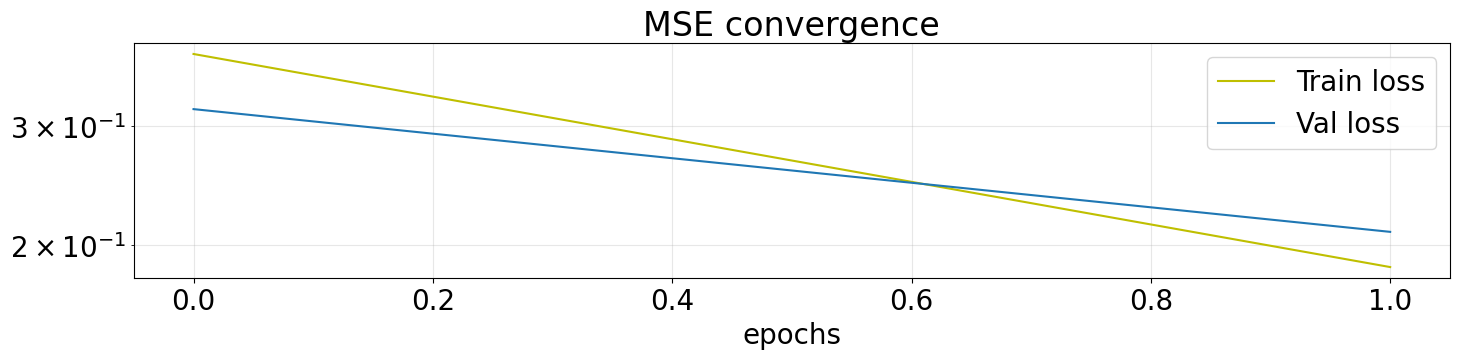

Plotting done


In [21]:
#plot convergence of training and validation loss (to visualise convergence during training)
# Disable LaTeX rendering
mpl.rcParams["text.usetex"] = False

plt.title('MSE convergence')
plt.yscale('log')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
plt.plot(tloss_plot[np.nonzero(tloss_plot)], 'y', label='Train loss')
plt.plot(np.arange(np.nonzero(vloss_plot)[0].shape[0])*N_check, vloss_plot[np.nonzero(vloss_plot)], label='Val loss')
plt.xlabel('epochs')
plt.legend()    
plt.tight_layout()
plt.show()

print("Plotting done")

# Visualize error

In [22]:
#load model for the test set
path = './data/48_RE30_'+str(N_lat)
os.makedirs(path, exist_ok=True)

a = [None] * N_parallel
b = [None] * N_parallel

for i in range(N_parallel):
    enc_path = f"{path}/enc_mod{ker_size[i]}_{N_lat}.h5"
    dec_path = f"{path}/dec_mod{ker_size[i]}_{N_lat}.h5"
    print(f"Loading models: encoder -> {enc_path}, decoder -> {dec_path}")

    if os.path.exists(enc_path) and os.path.exists(dec_path):
        try:
            a[i] = tf.keras.models.load_model(enc_path, custom_objects={"PerPad2D": PerPad2D})
            b[i] = tf.keras.models.load_model(dec_path, custom_objects={"PerPad2D": PerPad2D})
        except Exception as e:
            raise RuntimeError(f"Error loading models: {e}")
    else:
        raise FileNotFoundError(f"Model files not found: {enc_path}, {dec_path}")


Loading models: encoder -> ./data/48_RE30_5/enc_mod(3, 3)_5.h5, decoder -> ./data/48_RE30_5/dec_mod(3, 3)_5.h5
Loading models: encoder -> ./data/48_RE30_5/enc_mod(5, 5)_5.h5, decoder -> ./data/48_RE30_5/dec_mod(5, 5)_5.h5
Loading models: encoder -> ./data/48_RE30_5/enc_mod(7, 7)_5.h5, decoder -> ./data/48_RE30_5/dec_mod(7, 7)_5.h5


0


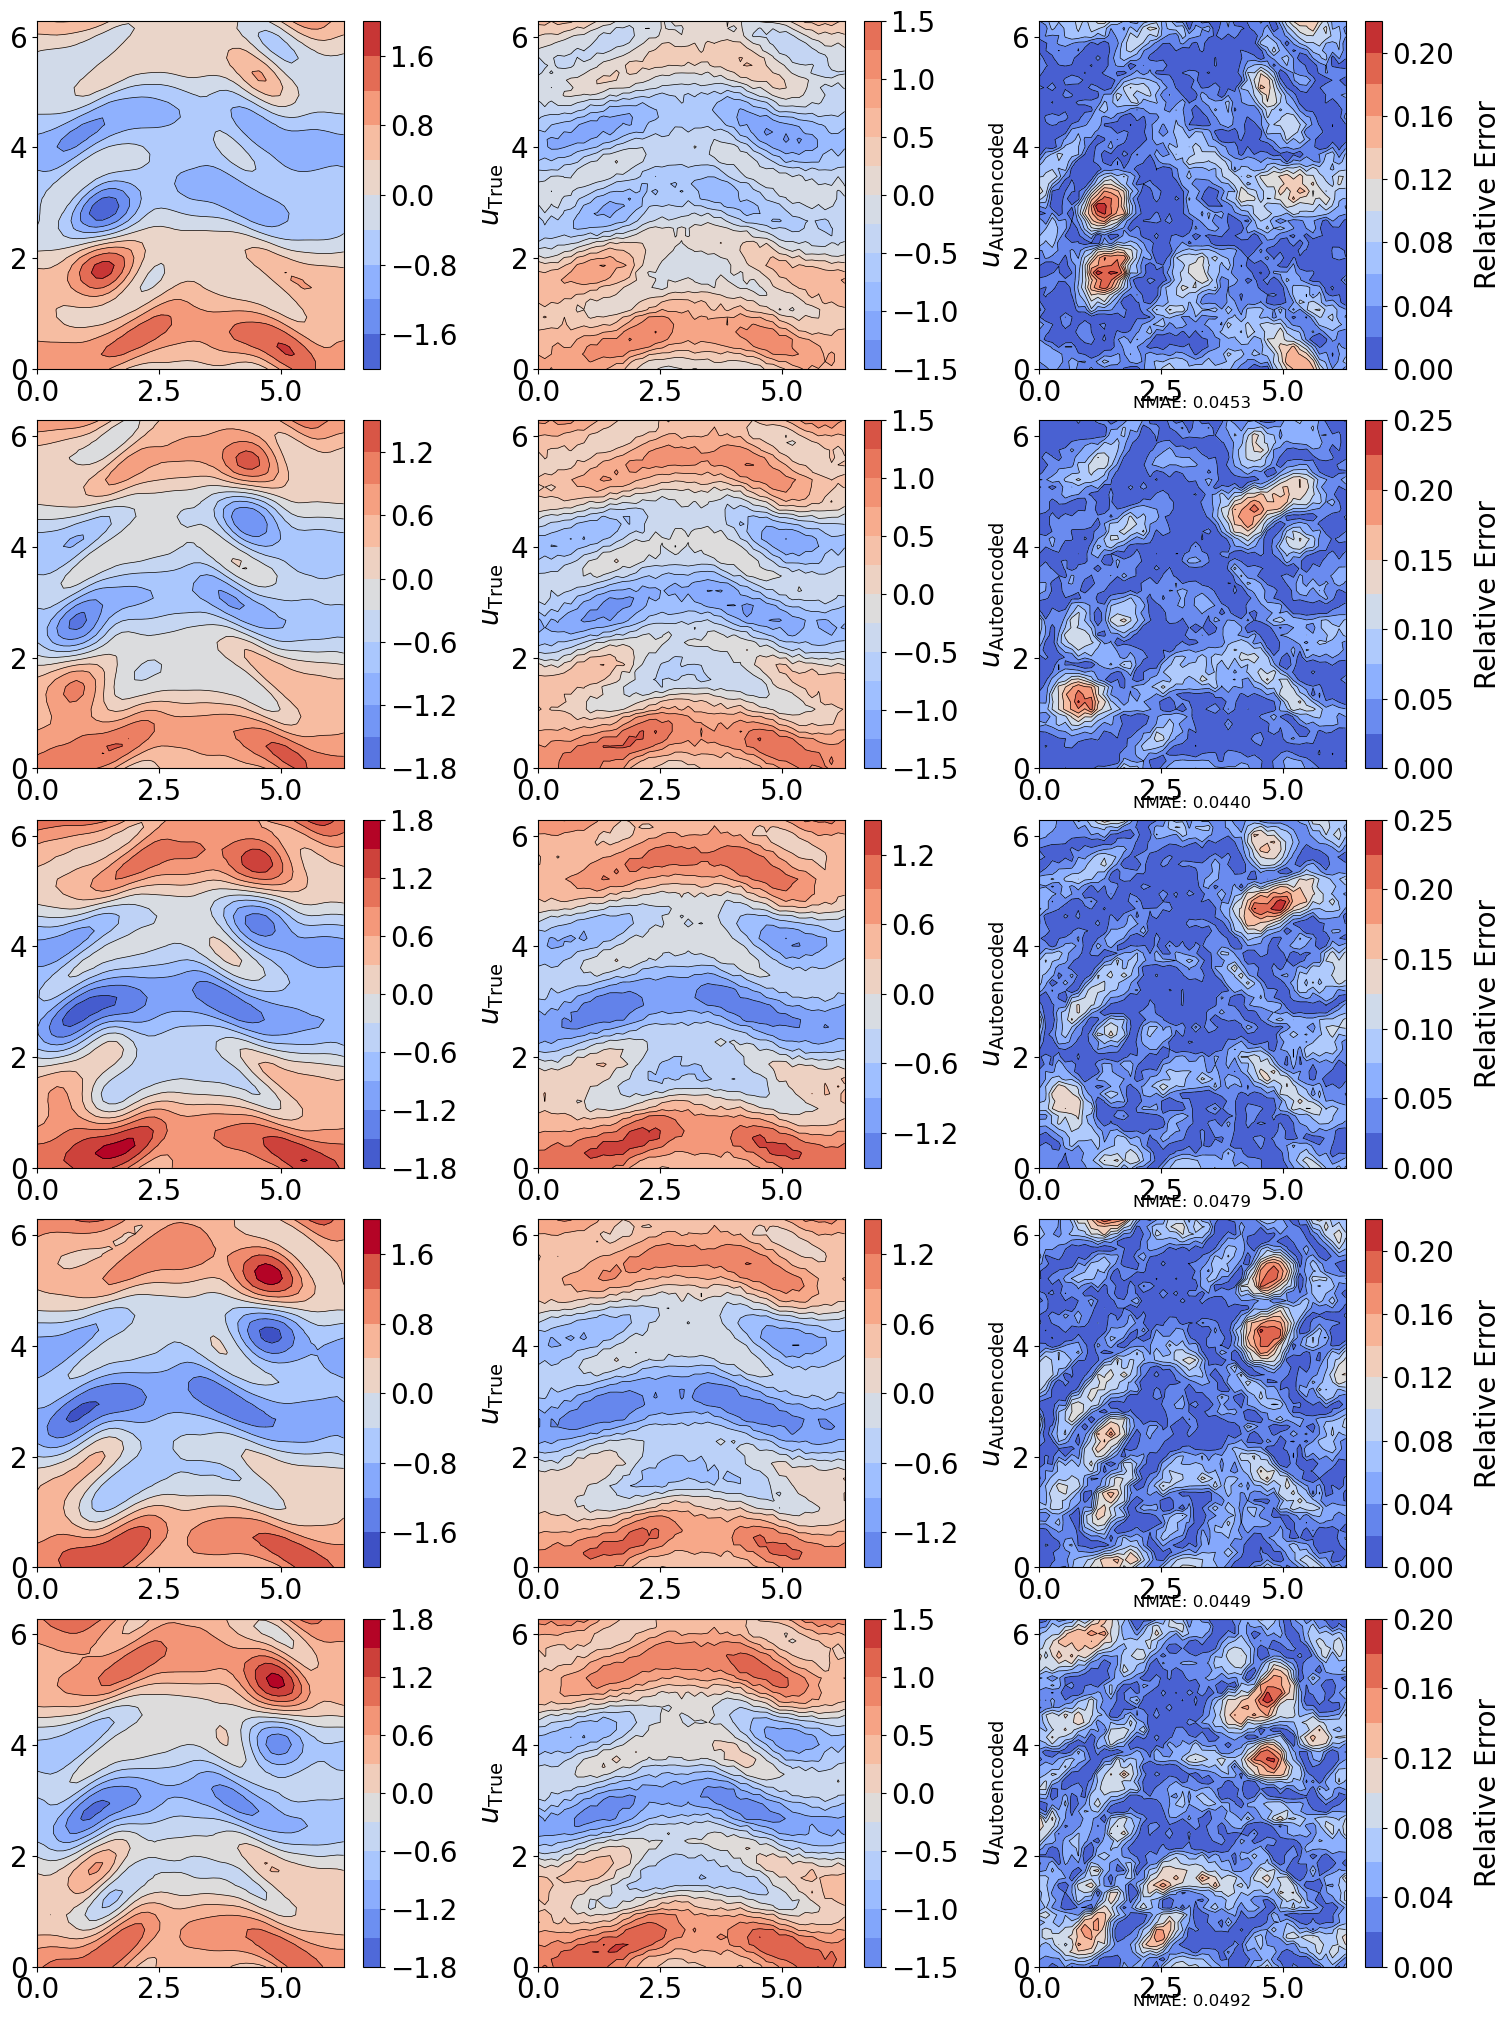

In [23]:
# grid
X       = np.linspace(0,2*np.pi,N_x) 
Y       = np.linspace(0,2*np.pi,N_y) 
XX      = np.meshgrid(X, Y, indexing='ij')

# plot n snapshots and their reconstruction in the test set.
n_snapshots = 5
plt.rcParams["figure.figsize"] = (15,4*n_snapshots)
plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(n_snapshots,3)

# start after validation set
start = 0 #b_size*n_batches*downsample + b_size*val_batches*downsample
print(start)

for i in range(n_snapshots):

    # testing data
    skips = 50
    u = U[start+500+i*skips:start+501+i*skips].copy()
    vmax = u.max()
    vmin = u.min()
    
    # truth
    plt.subplot(n_snapshots,3,i*3+1)

    CS0    = plt.contourf(XX[0], XX[1],u[0,:,:,0],
                          levels=10,cmap='coolwarm',vmin=vmin, vmax=vmax)
    cbar   = plt.colorbar()
    cbar.set_label('$u_{\mathrm{True}}$',labelpad=15)
    CS     = plt.contour(XX[0], XX[1],u[0,:,:,0],
                         levels=10,colors='black',linewidths=.5, linestyles='solid',
                         vmin=vmin, vmax=vmax)
    
    # autoencoded
    plt.subplot(n_snapshots,3,i*3+2)

    u_dec  = model(u,a,b)[1][0].numpy()
    CS     = plt.contourf(XX[0],XX[1],u_dec[:,:,0],
                        levels=10,cmap='coolwarm',vmin=vmin, vmax=vmax)
    cbar   = plt.colorbar()
    cbar.set_label('$u_{\mathrm{Autoencoded}}$',labelpad=15)
    CS     = plt.contour(XX[0], XX[1],u_dec[:,:,0],
                         levels=10,colors='black',linewidths=.5, linestyles='solid',
                         vmin=vmin, vmax=vmax)
    
    # error
    plt.subplot(n_snapshots,3,i*3+3)

    u_err  = np.abs(u_dec-u[0])/(vmax-vmin)
    nmae = u_err[:,:,0].mean()
    
    CS     = plt.contourf(XX[0], XX[1],u_err[:,:,0],levels=10,cmap='coolwarm')
    cbar   = plt.colorbar()
    cbar.set_label('Relative Error',labelpad=15)
    CS     = plt.contour(XX[0], XX[1],u_err[:,:,0],levels=10,colors='black',linewidths=.5, 
                         linestyles='solid')
    
    # Add NMAE text below the error image
    plt.text(0.5, -0.1, f'NMAE: {nmae:.4f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

fig.tight_layout(pad=0.1)
plt.savefig(path+'/Autoencoder_error.pdf')
plt.show()

# Save Encoded Data

In [24]:
'''
TODO: change path and parameters
'''
# save the encoded data for the ESN (too much memory used for GPU)
N_pos     = 5000 #split in k interval of N_pos length needed to process long timeseries
k         = 75
transient = 10000
N_len = k*N_pos
fln      = '/data/ar994/Python/data/Kolmogorov/Kolmogorov_0.1_48_30.0_100100_32.h5'
hf       = h5py.File(fln,'r')
dt       = 0.1
U        = np.array(hf.get('U')[transient:transient+N_len], dtype=np.float32)
hf.close()

N_x      = U.shape[1]
N_y      = U.shape[2]

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data/ar994/Python/data/Kolmogorov/Kolmogorov_0.1_48_30.0_100100_32.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
'''
TODO: change parameters
'''

Latents  = [N_lat]
Re       = 30

for N_latent in Latents:
    path = './data/48_RE30_'+str(N_latent)
    a = [None]*N_parallel
    b = [None]*N_parallel
    for i in range(N_parallel):
        a[i] = tf.keras.models.load_model(path + '/enc_mod'+str(ker_size[i])+'_'+str(N_latent)+'.h5', 
                                              custom_objects={"PerPad2D": PerPad2D})
    for i in range(N_parallel):
        b[i] = tf.keras.models.load_model(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_latent)+'.h5',
                                              custom_objects={"PerPad2D": PerPad2D})

    N_1   = [3,3,N_latent//9]
    U_enc = np.zeros((N_len, N_1[0], N_1[1], N_1[2]))
    #encode all the data to provide time series in latent space for the ESN
    for i in range(k):
        U_enc[i*N_pos:(i+1)*N_pos]= model(U[i*N_pos:(i+1)*N_pos], a, b)[0]

    fln = './data/48_Encoded_data_Re30_' \
                + str(N_latent) +'.h5'
    hf = h5py.File(fln,'w')
    hf.create_dataset('U_enc'      ,data=U_enc)  
    hf.close()
    print(fln)

In [ ]:
def gradient(U,dx,dy,n_splits):
    '''Returns dissipation of U, done in n_splits'''
    
    shapes    = np.array(U.shape)
    shapes[0] = shapes[0]//n_splits
    dU_dx     = np.empty(shapes)
    dU_dy     = np.empty(shapes)
    D         = np.empty(shapes[0]*n_splits)
    
    for i in np.arange(n_splits):
        
        for j in range(shapes[1]):
            dU_dx[:,j] = (U[i*shapes[0]:(i+1)*shapes[0],(j+1)%shapes[1]] - \
                          U[i*shapes[0]:(i+1)*shapes[0],j-1])/(2*dx)
        for k in range(shapes[2]):
            dU_dy[:,:,k] = (U[i*shapes[0]:(i+1)*shapes[0],:,(k+1)%shapes[2]] - \
                            U[i*shapes[0]:(i+1)*shapes[0],:,k-1])/(2*dy)
            
        D[i*shapes[0]:(i+1)*shapes[0]] =  np.mean(dU_dx**2+dU_dy**2,
                                            axis=(1,2,3))/Re*4
              
    return D

In [ ]:
plt.rcParams["figure.figsize"] = (15,4)
plt.rcParams["font.size"] = 20

#plot average dissipation rate
plt.subplot(121)
leng      = 5000
dx        = 2*np.pi/(N_x-1)
DD        = gradient(U[-leng:],dx,dx,1) #true
U_dec     = model(U[-leng:], a, b)[1]
DD_enc    = gradient(U_dec,dx,dx,1) #autoencoded
plt.plot(DD,'w')
plt.plot(DD_enc,'r--')

#plot error
plt.subplot(122)
plt.plot(np.abs(DD_enc-DD)/(DD.max()-DD.min()))
plt.tight_layout()
plt.show()
print(np.mean(np.abs(DD_enc-DD)/(DD.max()-DD.min())))

In [ ]:
"""
TODO: implement decoding
"""